#### The objective is to build and train a ML model to estimate the energy consumed by different 5G base stations taking into consideration the impact of various engineering configurations, traffic conditions, and energy-saving methods.

In [23]:
# import libraries
import pandas as pd
import numpy as np

# for visuals
import seaborn as sns
import matplotlib.pyplot as  plt

%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [24]:
df = pd.read_csv(r"C:\Users\josep\OneDrive\Desktop\Datasets\5G_energy_consumption_dataset.csv")
df

,Time,BS,Energy,load,ESMODE,TXpower
0,20230101 010000,B_0,64.275037,0.487936,0.0,7.101719
1,20230101 020000,B_0,55.904335,0.344468,0.0,7.101719
2,20230101 030000,B_0,57.698057,0.193766,0.0,7.101719
3,20230101 040000,B_0,55.156951,0.222383,0.0,7.101719
4,20230101 050000,B_0,56.053812,0.175436,0.0,7.101719
...,...,...,...,...,...,...
92624,20230102 170000,B_1018,14.648729,0.087538,0.0,7.325859
92625,20230102 180000,B_1018,14.648729,0.082635,0.0,7.325859
92626,20230102 210000,B_1018,13.452915,0.055538,0.0,7.325859
92627,20230102 220000,B_1018,13.602392,0.058077,0.0,7.325859


### Data Inspection

In [25]:
df.shape

(92629, 6)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92629 entries, 0 to 92628
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Time     92629 non-null  object 
 1   BS       92629 non-null  object 
 2   Energy   92629 non-null  float64
 3   load     92629 non-null  float64
 4   ESMODE   92629 non-null  float64
 5   TXpower  92629 non-null  float64
dtypes: float64(4), object(2)
memory usage: 4.2+ MB


In [27]:
df.dtypes

Time        object
BS          object
Energy     float64
load       float64
ESMODE     float64
TXpower    float64
dtype: object

In [28]:
df.isnull().sum()

Time       0
BS         0
Energy     0
load       0
ESMODE     0
TXpower    0
dtype: int64

In [29]:
df.duplicated().sum()

0

In [30]:
# summary statistics of the data
df.describe().astype('int')

,Energy,load,ESMODE,TXpower
count,92629,92629,92629,92629
mean,28,0,0,6
std,13,0,0,0
min,0,0,0,5
25%,18,0,0,6
50%,24,0,0,6
75%,35,0,0,6
max,100,0,4,8


This summary provides insights into the central tendency, variability, and distribution of each variable within the dataset. For example, the Energy variable has a wide range of values from 0 to 100, with a mean of 28 and a standard deviation of 13, indicating some variability in the data. The Load and ESMODE variables have constant values with zero variance, while the TXpower variable ranges from 5 to 8, with most values centered around 6.

In [31]:
# Import pandas profiling library
from ydata_profiling import ProfileReport

# Create a pandas profiling reports to gain insights into the dataset
Profile = ProfileReport(df, title="Pandas Profile Report")
Profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Data Preprocessing

drop duplicate rows

df.drop_duplicates(keep = 'first', inplace =True) print('\nDataFrame after dropping duplicate rows: ') df

In [32]:
df.columns.tolist()

['Time', 'BS', 'Energy', 'load', 'ESMODE', 'TXpower']

In [33]:
# select numerical variables
num_vars = df.select_dtypes(include = ['float', 'int64']).columns.tolist()
print(num_vars)

# value counts for numerical variables
for column in num_vars:
    print(df[column].value_counts())

['Energy', 'load', 'ESMODE', 'TXpower']
Energy
17.937220    1014
17.787743     921
18.236173     898
18.385650     895
18.086697     889
             ... 
98.355755       1
85.650224       1
97.010463       1
96.711510       1
96.412556       1
Name: count, Length: 612, dtype: int64
load
0.008260    71
0.008240    71
0.045923    70
0.008270    55
0.008300    49
            ..
0.569074     1
0.610043     1
0.285777     1
0.467277     1
0.058077     1
Name: count, Length: 58563, dtype: int64
ESMODE
0.000000    87475
2.000000     1299
1.999722      226
0.002500      134
0.000556      122
            ...  
0.378611        1
1.805833        1
1.467778        1
0.317500        1
0.983333        1
Name: count, Length: 1713, dtype: int64
TXpower
6.875934    40444
6.427504    26693
7.100897    13277
7.101719     2523
6.876682     1445
6.128550      986
7.325859      879
5.979073      781
6.651719      673
8.034529      342
6.726457      336
6.576981      332
5.680120      329
6.727205      325


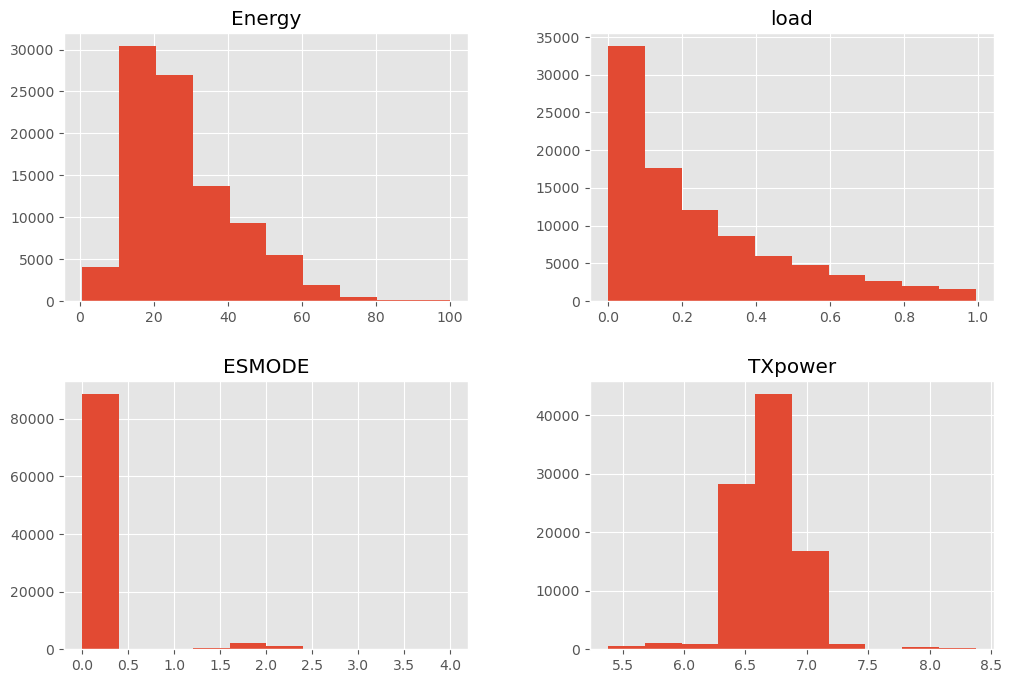

In [34]:
# Showing the distribution of numeric columns
df.hist(figsize = (12,8));

### Handling Outliers

Energy     2192
load       2974
ESMODE     5154
TXpower    1169
dtype: int64


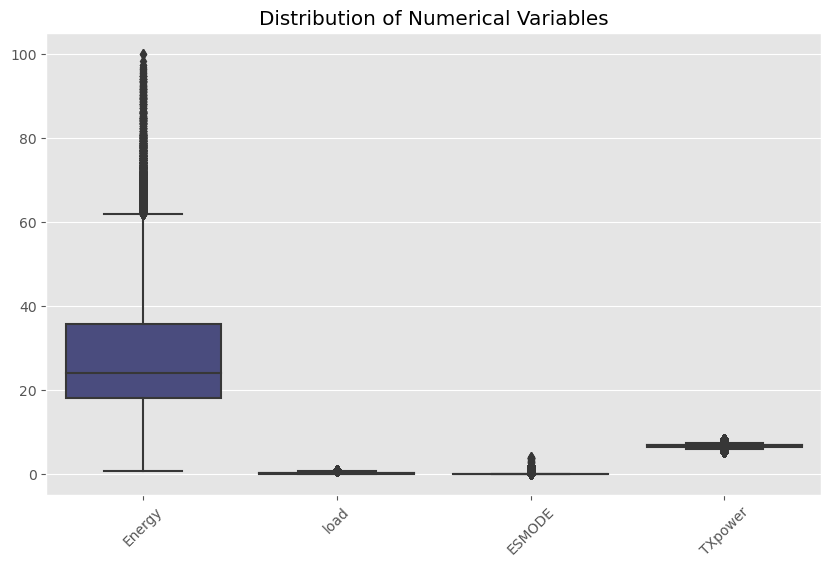

In [35]:
# Extract the numerical columns from the dataset
num_vars = df.select_dtypes(include=['int64', 'float64'])

# Calculate the number of outliers for each numerical variable
outliers_count = ((num_vars < num_vars.quantile(0.25) - 1.5 * (num_vars.quantile(0.75) - num_vars.quantile(0.25))) |
                  (num_vars > num_vars.quantile(0.75) + 1.5 * (num_vars.quantile(0.75) - num_vars.quantile(0.25))))
outliers_count = outliers_count.sum()

# Display the number of outliers in a table
print(outliers_count)

# Create a boxplot to show the distribution of each numerical variable
plt.figure(figsize=(10, 6))
sns.boxplot(data=num_vars, palette='viridis')
plt.title('Distribution of Numerical Variables')
plt.xticks(rotation=45)
plt.show()

### Removing the Outliers

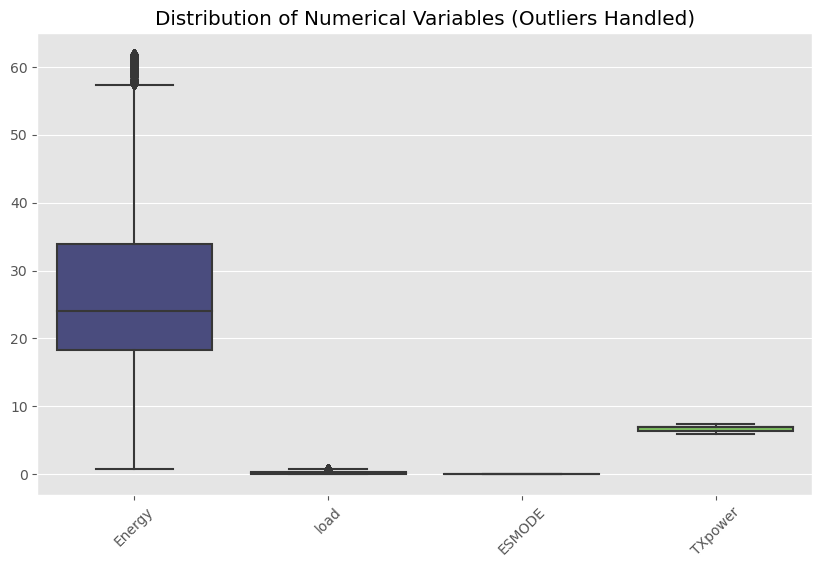

In [36]:
# Calculate the median of each numerical variable
medians = num_vars.median()

# Replace outliers with the median of each variable
for column in num_vars.columns:
    q1 = num_vars[column].quantile(0.25)
    q3 = num_vars[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    num_vars[column] = num_vars[column].apply(lambda x: medians[column] if x < lower_bound or x > upper_bound else x)

# Create a boxplot to show the distribution of each numerical variable after handling outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=num_vars, palette='viridis')
plt.title('Distribution of Numerical Variables (Outliers Handled)')
plt.xticks(rotation=45)
plt.show()

The outliers in the numerical variables has been removed by replacing it with the median of the columns.

In [37]:
# select categorical variables
cat_vars = df.select_dtypes(include = ['object']).columns.tolist()
print(cat_vars)

# value counts for categorical variables
for column in cat_vars:
    print(df[column].value_counts())

['Time', 'BS']
Time
20230102 230000    766
20230102 180000    759
20230102 210000    757
20230102 020000    756
20230102 000000    756
                  ... 
20230107 170000    161
20230107 010000    151
20230107 160000    149
20230107 130000    140
20230108 000000     42
Name: count, Length: 168, dtype: int64
BS
B_583     130
B_261     128
B_728     128
B_669     128
B_512     126
         ... 
B_1018     16
B_921      14
B_905      13
B_854       1
B_835       1
Name: count, Length: 923, dtype: int64


In [38]:
df.drop(columns="Time", inplace=True)

In [39]:
df

,BS,Energy,load,ESMODE,TXpower
0,B_0,64.275037,0.487936,0.0,7.101719
1,B_0,55.904335,0.344468,0.0,7.101719
2,B_0,57.698057,0.193766,0.0,7.101719
3,B_0,55.156951,0.222383,0.0,7.101719
4,B_0,56.053812,0.175436,0.0,7.101719
...,...,...,...,...,...
92624,B_1018,14.648729,0.087538,0.0,7.325859
92625,B_1018,14.648729,0.082635,0.0,7.325859
92626,B_1018,13.452915,0.055538,0.0,7.325859
92627,B_1018,13.602392,0.058077,0.0,7.325859


In [40]:
from sklearn.preprocessing import LabelEncoder

# Assuming 'df' is your DataFrame
columns_to_encode = ["BS"]

# Create a label encoder instance
label_encoder = LabelEncoder()

# Apply label encoding to each categorical column
for column in columns_to_encode:
    df[column] = label_encoder.fit_transform(df[column])

# Display the updated DataFrame
print(df.head())

   BS     Energy      load  ESMODE   TXpower
0   0  64.275037  0.487936     0.0  7.101719
1   0  55.904335  0.344468     0.0  7.101719
2   0  57.698057  0.193766     0.0  7.101719
3   0  55.156951  0.222383     0.0  7.101719
4   0  56.053812  0.175436     0.0  7.101719


## Model Selection for Predicting Energy Consumed by different 5G Base Stations
    It is a regression task. In this task we will be using the following algorithmns
    Linear regression
    Decision tree regression
    Random forest regression
    Lasso Regression

### Feature Selections
    The target is what you want to predict. In this case, we want to predict energy consumed.
    The independent variables after dropping the target is our X, which is what we are going to train our model.

In [41]:
# the target is usually named as y
y = df['Energy']
y.head()

0    64.275037
1    55.904335
2    57.698057
3    55.156951
4    56.053812
Name: Energy, dtype: float64

In [42]:
X = df.drop("Energy", axis=1)
X.head()

,BS,load,ESMODE,TXpower
0,0,0.487936,0.0,7.101719
1,0,0.344468,0.0,7.101719
2,0,0.193766,0.0,7.101719
3,0,0.222383,0.0,7.101719
4,0,0.175436,0.0,7.101719


## Train-Test-Split
We will split the dataset into training and testing set. Typically, we will allocate a certain percentage of 70-30 for training and testing, respectively. This will be done using the train_test_split function from scikit-learn.

In [43]:
from sklearn.model_selection import train_test_split

# split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

print('\n', X_train.head(2))
print('\n', X_test.head(2))
print('\n', y_train.head(2))
print('\n', y_test.head(2))


         BS      load  ESMODE   TXpower
47956  378  0.502570     0.0  7.100897
91857  885  0.070096     0.0  7.325859

         BS      load    ESMODE   TXpower
65601  553  0.372528  0.000000  7.100897
2220   129  0.013640  1.885278  6.875934

 47956    56.950673
91857    14.648729
Name: Energy, dtype: float64

 65601    44.843049
2220     20.478326
Name: Energy, dtype: float64


In [44]:
# check the shape of the splitted data
print(f'The X_train shape: {X_train.shape}')
print(f'The X_test shape: {X_test.shape}')
print(f'The y_train shape: {y_train.shape}')
print(f'The y_test shape: {y_test.shape}')

The X_train shape: (64840, 4)
The X_test shape: (27789, 4)
The y_train shape: (64840,)
The y_test shape: (27789,)


## Standardization
We will scale the features of the data using MinMax Scaler from scikit-learn.

In [45]:
from sklearn.preprocessing import MinMaxScaler

# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and test data
X_test_scaled = scaler.transform(X_test)


## Model Building

In [46]:
# import the necessary libraries for the model building
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# algorithms for the evaluation of model performance
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## Linear Regression

In [47]:
lr_model = LinearRegression()

# fit the the model
lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [48]:
# create predictions
y_pred = lr_model.predict(X_test_scaled)

In [49]:
# manually compare the energy consumed
print('Actual Energy: ', y.head().tolist())
print('..........................................')
print('Predicted Energy: ', np.round(y_pred[:5].tolist(), 2))

Actual Energy:  [64.27503737, 55.90433483, 57.6980568, 55.15695067, 56.05381166]
..........................................
Predicted Energy:  [37.78 11.44 17.94 44.75 20.24]


In [50]:
# model evaluation
linear_mse = mean_squared_error(y_test, y_pred)
linear_r2 = r2_score(y_test, y_pred)
linear_mae = mean_absolute_error(y_test, y_pred)
linear_rmse = mean_squared_error(y_test, y_pred, squared = False)

print('R2 of Linear Regression:', linear_r2.round(2))
print('MAE of Linear Regression:', linear_mae.round(2))
print('MSE of Linear Regression:', linear_mse.round(2))
print('RMSE of Linear Regression:', linear_rmse.round(2))

R2 of Linear Regression: 0.56
MAE of Linear Regression: 6.88
MSE of Linear Regression: 85.53
RMSE of Linear Regression: 9.25


### Random Forest Regressor

In [51]:
rf_model = RandomForestRegressor()

# fit the the model
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor()

In [52]:
# create predictions
y_pred = rf_model.predict(X_test_scaled)

In [53]:
# manually compare the energy consumed
print('Actual Energy: ', y.head().tolist())
print('..........................................')
print('Predicted Energy: ', np.round(y_pred[:5].tolist(), 2))

Actual Energy:  [64.27503737, 55.90433483, 57.6980568, 55.15695067, 56.05381166]
..........................................
Predicted Energy:  [49.08 10.51 14.56 56.76 38.2 ]


In [54]:
# model evaluation
rf_mse = mean_squared_error(y_test, y_pred)
rf_r2 = r2_score(y_test, y_pred)
rf_mae = mean_absolute_error(y_test, y_pred)
rf_rmse = mean_squared_error(y_test, y_pred, squared = False)

print('R2 of Random Forest Regressor:', rf_r2.round(2))
print('MAE of Random Forest Regressor:', rf_mae.round(2))
print('MSE of Random Forest Regressor:', rf_mse.round(2))
print('RMSE of Random Forest Regressor:', rf_rmse.round(2))

R2 of Random Forest Regressor: 0.94
MAE of Random Forest Regressor: 2.08
MSE of Random Forest Regressor: 10.85
RMSE of Random Forest Regressor: 3.29


### Decision Tree

In [55]:
dc_model = DecisionTreeRegressor()

# fit the the model
dc_model.fit(X_train_scaled, y_train)

DecisionTreeRegressor()

In [56]:
# create predictions
y_pred = dc_model.predict(X_test_scaled)

In [57]:
# manually compare the energy consumed
print('Actual Energy: ', y.head().tolist())
print('..........................................')
print('Predicted Energy: ', np.round(y_pred[:5].tolist(), 2))

Actual Energy:  [64.27503737, 55.90433483, 57.6980568, 55.15695067, 56.05381166]
..........................................
Predicted Energy:  [55.01 10.31 13.75 55.16 38.27]


In [58]:
# model evaluation
dc_mse = mean_squared_error(y_test, y_pred)
dc_r2 = r2_score(y_test, y_pred)
dc_mae = mean_absolute_error(y_test, y_pred)
dc_rmse = mean_squared_error(y_test, y_pred, squared = False)

print('R2 of Decision Tree Regressor:', dc_r2.round(2))
print('MAE of Decision Tree Regressor:', dc_mae.round(2))
print('MSE of Decision Tree Regressor:', dc_mse.round(2))
print('RMSE of Decision Tree Regressor:', dc_rmse.round(2))

R2 of Decision Tree Regressor: 0.91
MAE of Decision Tree Regressor: 2.55
MSE of Decision Tree Regressor: 17.79
RMSE of Decision Tree Regressor: 4.22


### Lasso Regression

In [59]:
lasso_model =  Lasso(alpha = 0.5)

# fit the the model
lasso_model.fit(X_train_scaled, y_train)

Lasso(alpha=0.5)

In [60]:
# create predictions
y_pred = lasso_model.predict(X_test_scaled)

In [61]:
# manually compare the energy consumed
print('Actual Energy: ', y.head().tolist())
print('..........................................')
print('Predicted Energy: ', np.round(y_pred[:5].tolist(), 2))

Actual Energy:  [64.27503737, 55.90433483, 57.6980568, 55.15695067, 56.05381166]
..........................................
Predicted Energy:  [31.98 21.44 23.2  38.76 21.53]


In [62]:
# model evaluation
lasso_mse = mean_squared_error(y_test, y_pred)
lasso_r2 = r2_score(y_test, y_pred)
lasso_mae = mean_absolute_error(y_test, y_pred)
lasso_rmse = mean_squared_error(y_test, y_pred, squared = False)

print('R2 of Lasso Regressor:', lasso_r2.round(2))
print('MAE of Lasso Regressor:', lasso_mae.round(2))
print('MSE of Lasso Regressor:', lasso_mse.round(2))
print('RMSE of Lasso Regressor:', lasso_rmse.round(2))

R2 of Lasso Regressor: 0.4
MAE of Lasso Regressor: 8.3
MSE of Lasso Regressor: 116.38
RMSE of Lasso Regressor: 10.79


### Model Conclusion

The provided summary presents evaluation metrics for a Random Forest Regressor model:

The R2 score, a measure of how well the model explains the variance in the data, is 0.94, indicating that the model explains 94% of the variance in the target variable.

The Mean Absolute Error (MAE) is 2.08, which represents the average absolute difference between the predicted and actual values. Lower MAE indicates better model performance.

The Mean Squared Error (MSE) is 10.85, representing the average of the squares of the errors between predicted and actual values. Lower MSE indicates better model performance.

The Root Mean Squared Error (RMSE) is 3.29, which is the square root of the MSE and provides a measure of the average magnitude of error in the predicted values. Lower RMSE indicates better model performance.

Overall, these metrics suggest that the Random Forest Regressor model performs well in predicting the target variable, with low error rates and high explanatory power.




